#  <div align='center'>第8章 非参数统计(4)</div>

In [2]:
%reset -f
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.stats.anova as sma
import statsmodels.formula.api as smf
import statsmodels.stats.api as smt
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
import statsmodels.nonparametric.api as smn
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

----------

## 8.7 非参数密度估计
数据的概率分布无法事先确定时，可使用非参数密度估计方法。

### 8.7.1 直方图密度估计

- #### 示例：
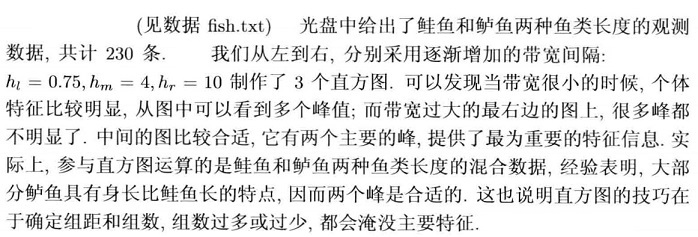

In [3]:
fish = pd.read_csv('e:\\data\\fish.txt',delim_whitespace = True)
fish.head()

,length,luminous
31,12.785730,4.437141
32,6.533526,4.780177
33,15.458891,5.326050
34,13.754025,5.416128
35,13.135536,5.887023


- #### 最佳带宽


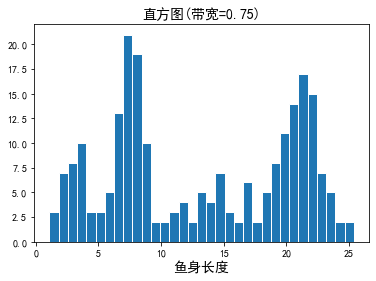

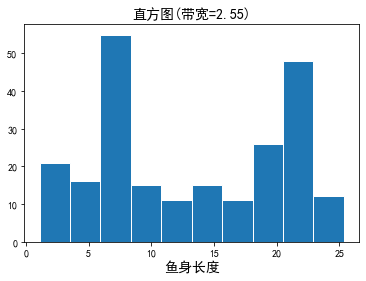

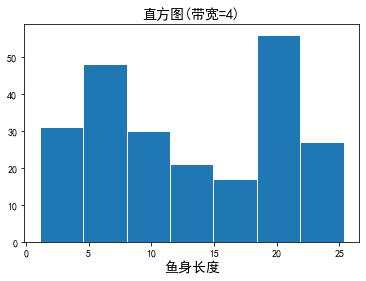

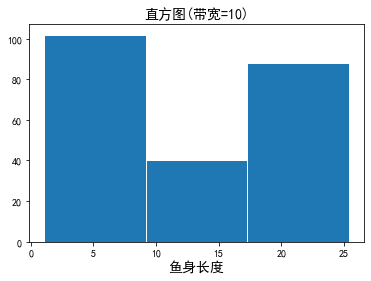

In [4]:
#plt.scatter(fish.luminous,fish.length)
lmin=np.min(fish.length)#最小长度
lmax=np.max(fish.length)#最大长度
ldiff=lmax-lmin##极差

###通过宽度求直方图bin的个数
#bin的个数等于极差除以带宽，注意带宽是整数，需要进行转换。
#带宽为[0.75,2.55,4,10]

##通过最佳带宽公式求出来的h值约等于2.55。
h=1.06*np.std(fish.length)*len(fish.length)**(-1/5)

for i in [0.75,2.55,4,10]:
    plt.figure()
    bins=int(np.ceil(ldiff/i))
    plt.hist(fish.length,bins=bins,edgecolor='w')
    plt.title('直方图(带宽={})'.format(str(i)),size=14)
    plt.xlabel('鱼身长度',size=14)
plt.show()

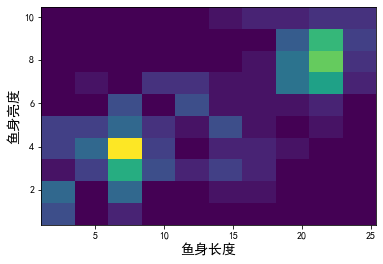

In [5]:
'''
多维直方图，此处以二维直方图为例。
'''
plt.hist2d(fish.length,fish.luminous)
plt.xlabel('鱼身长度',size=14)
plt.ylabel('鱼身亮度',size=14)
plt.show()

### 8.7.2 核密度估计


- #### 示例：使用鲑鱼和鲈鱼长度和亮度例子进行核密度估计。带宽分别为：0.3、 1.0、 2.55、 5.0.

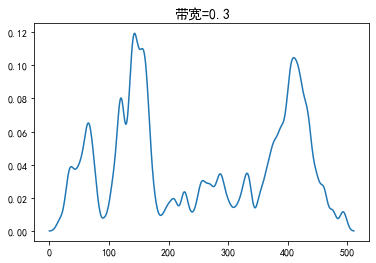

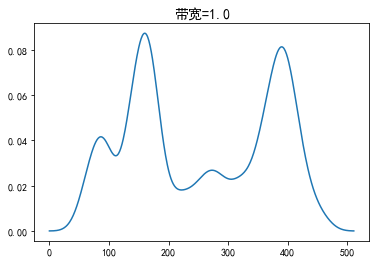

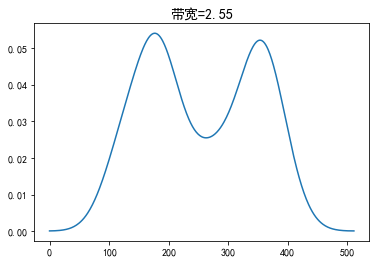

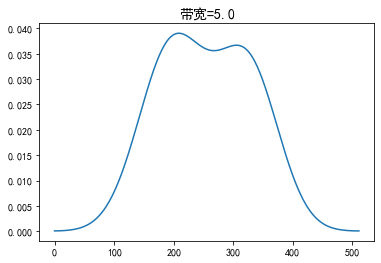

In [6]:
'''
非参数统计。
'''
dens = smn.KDEUnivariate(fish.length)
###h=2.55在前面直方图密度估计的示例中已经计算
bw = [0.3,1.0,2.55,5.0]
for i in bw:
    plt.figure()
    result = dens.fit(bw=i,kernel='gau')
    plt.title('带宽={0}'.format(i),size=14)
    plt.plot(result.density)
#plt.ylim(0,np.max(result.density)*1.1)
plt.show()

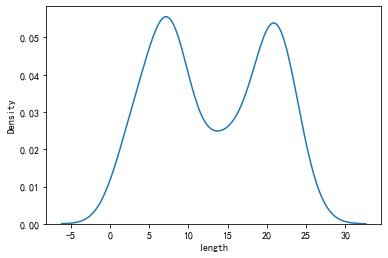

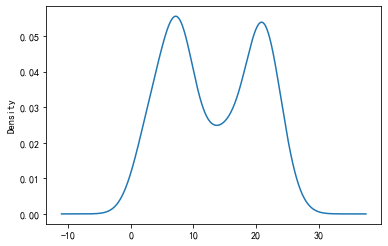

In [7]:
### 通过Seaborn和pandas也可以绘制核密度估计曲线
sns.kdeplot(fish.length)
plt.figure()
fish.length.plot(kind='kde')
plt.show()

- #### 多维核密度估计


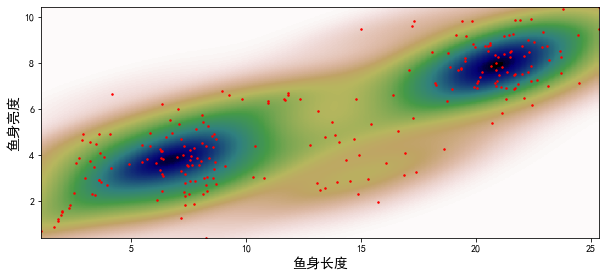

In [8]:
'''
Scipy的多维高斯核密度估计。
'''
### m1：鱼身长度，m2：鱼身亮度
m1, m2 = fish.length,fish.luminous
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

###根据鱼身长度和亮度的最小和最大值，生成网格点坐标矩阵
#便于绘制等高线图
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])

###高斯核密度估计
kernel = st.gaussian_kde(values)
Z = np.reshape(kernel(positions), X.shape)
fig, ax = plt.subplots(figsize=(10,8))

###显示核密度估计的概率密度，红点表示鱼身长度和亮度散点图。
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'r.', markersize=3)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.xlabel('鱼身长度',size=14)
plt.ylabel('鱼身亮度',size=14)
plt.show()

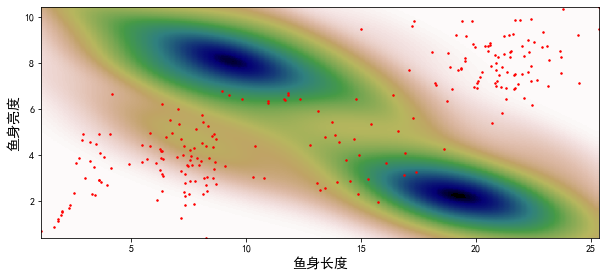

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
###不旋转密度曲面
ax.imshow(Z, cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'r.', markersize=3)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.xlabel('鱼身长度',size=14)
plt.ylabel('鱼身亮度',size=14)
plt.show()

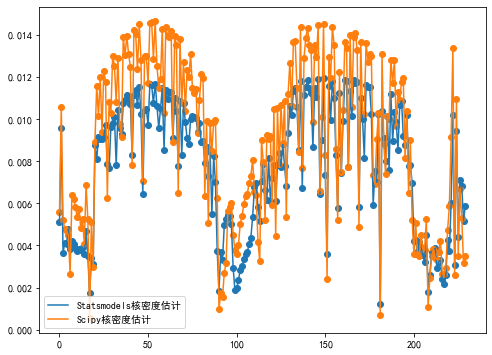

In [10]:
'''
使用Statsmodels的KDEMultivariate类进行高斯核密度估计。
'''
###var_type参数的值为cc表示二维数据都是连续型随机变量。
mdens=smn.KDEMultivariate(fish,var_type='cc')

###调用多元核密度估计返回的密度函数值
Z1=mdens.pdf()

###应用Scipy的高斯核估计密度函数值
Z2=kernel.pdf([m1,m2])

###绘制两种密度估计函数计算出来的概率密度函数值曲线，二者都使用高斯核
plt.figure(figsize=(8,6))
plt.plot(Z1,label='Statsmodels核密度估计')
plt.plot(Z2,label='Scipy核密度估计')
plt.scatter(range(0,len(Z1)),Z1)
plt.scatter(range(0,len(Z2)),Z2)
plt.legend()
plt.show()

-----------

## 8.8  一元非参数回归


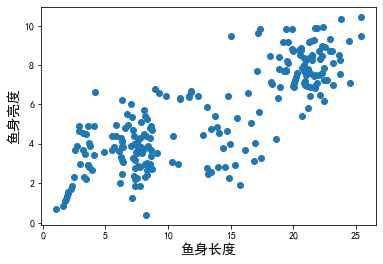

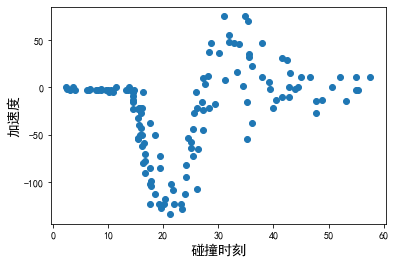

,times,accel
0,2.4,0.0
1,2.6,-1.3
2,3.2,-2.7
3,3.6,0.0
4,4.0,-2.7


In [11]:
'''
鱼身长度与亮度之间以及摩托车碰撞时刻与头部加速度之间的散点图。
'''
###鱼类数据的散点图
plt.figure(figsize=(6,4))
plt.scatter(m1,m2)
plt.xlabel('鱼身长度',size=14)
plt.ylabel('鱼身亮度',size=14)
###摩托车碰撞散点图
mc=pd.read_csv('e:\\data\\mcycle.csv')
mc1=mc.times
mc2=mc.accel
plt.figure(figsize=(6,4))
plt.scatter(mc1,mc2)
plt.xlabel('碰撞时刻',size=14)
plt.ylabel('加速度',size=14)
plt.show()
mc.head()

### 8.8.1 核回归光滑模型


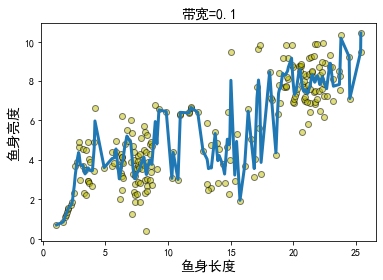

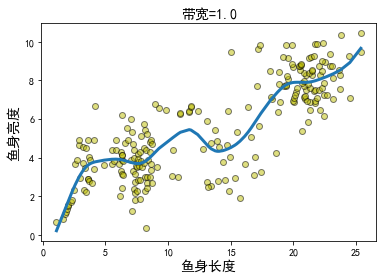

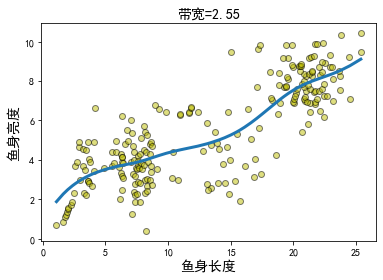

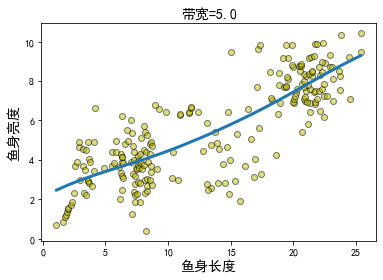

In [12]:
'''
通过鱼类数据进行核光滑回归。
'''
###根据不同的带宽调用Statsmodels的核回归光滑函数
#var_type参数表明数据是连续型随机变量

for bw in [0.1,1.0,2.55,5.0]:
    result = smn.KernelReg(m2,m1,bw=[bw],var_type='c').fit()
    data1  = pd.DataFrame(np.c_[m1,result[0]])

    ###对数据进行排序.如不排序，回归曲线是紊乱的
    data1 = data1.sort_values(by=0)
    plt.figure(figsize=(6,4))
    plt.xlabel('鱼身长度',size=14)
    plt.ylabel('鱼身亮度',size=14)
    plt.scatter(m1,m2,c='y',edgecolor='k',alpha=0.5)
    plt.title('带宽={0}'.format(bw),size=14)
    plt.plot(data1[0],data1[1],label='核回归光滑',lw=3)
    
plt.show()

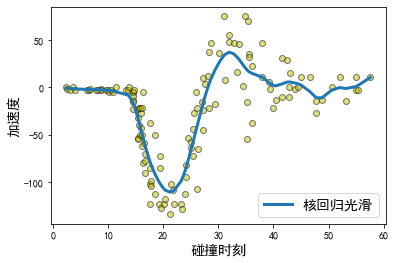

In [13]:
'''
通过摩托车碰撞数据进行核光滑回归。
以碰撞时刻mc1为自变量，加速度mc2为因变量。
'''
###如不指定bw参数的值，默认为‘cv_ls’，
#即least-squares cross-validation，
#通过"最小二乘交叉验证"算法获得最佳带宽
result2 = smn.KernelReg(mc2,mc1,var_type='c').fit()
data2  = pd.DataFrame(np.c_[mc1,result2[0]])
data2 = data2.sort_values(by=0)
plt.figure(figsize=(6,4))
plt.xlabel('碰撞时刻',size=14)
plt.ylabel('加速度',size=14)
plt.scatter(mc1,mc2,c='y',edgecolor='k',alpha=0.5)
plt.plot(data2[0],data2[1],label='核回归光滑',lw=3)
plt.legend(fontsize=14, loc='lower right')
plt.show()

### 8.8.2 局部多项式回归

- #### 例1：通过模拟数据比较LOESS和核回归光滑

<Figure size 432x288 with 0 Axes>

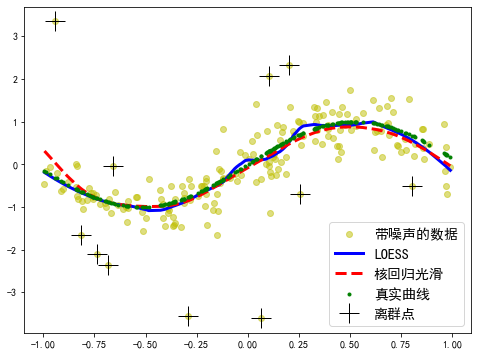

In [14]:
import loess
from loess.loess_1d import loess_1d
'''
生成模拟数据测试局部回归与核光滑回归模型之间的差别。
'''
def test_loess_1d():
    n = 200 #200条数据
    np.random.seed(123)
    x = np.random.uniform(-1, 1, n)
    x.sort()#排序
    y = np.sin(3*x)
    sigy = 0.4#标准差
    yran = np.random.normal(y, sigy)
    nbad = int(n*0.1) # 10%数据为离群点
    w = np.random.randint(0, n, nbad)  # 离群点数据的随机索引
    
    ###将响应变量中索引为w的数据设置成离群点
    yran[w] += np.random.normal(0, 5*sigy, nbad)
    
    ###调用loess函数进行局部回归。
    xout, yout, weigts = loess_1d(x, yran, frac=0.3,degree=2)
    
    ###核光滑回归模型
    #result[0]是响应变量回归值
    #一定要根据x进行排序
    result = smn.KernelReg(yran,x,var_type='c').fit()
    data  = pd.DataFrame(np.c_[x,result[0]]).sort_values(by=0)  
    
    ###权重小于0.34的数据点为离群点
    w = weigts < 0.34  
    plt.clf()
    plt.figure(figsize=(8,6))
    plt.plot(x, yran, 'yo',alpha=0.5 ,label='带噪声的数据')
    plt.plot(xout, yout, 'b', linewidth=3, label='LOESS')
    plt.plot(data[0],data[1],'r--',label='核回归光滑',lw=3)
    plt.plot(x, y, 'g.', linewidth=3, label='真实曲线')
    plt.plot(x[w], yran[w], '+k', ms=20, label='离群点')
    plt.legend(loc='lower right',fontsize=14)
    plt.show()
    
#调用函数
test_loess_1d()


- #### 例2：通过鱼类数据比较多项式回归与核光滑回归

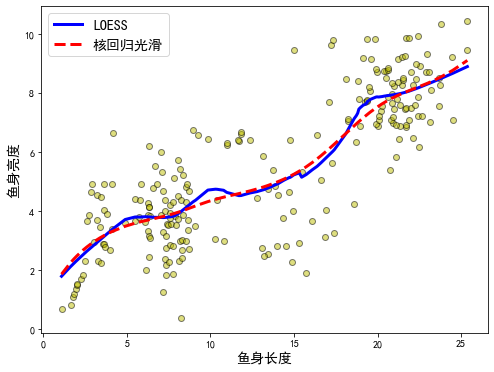

In [15]:
'''
例2：
通过鱼类数据进行局部多项式回归和核光滑回归。
'''

###局部多项式回归，此处没有指定degree的值，默认等于1
xout, yout, weigts = loess_1d(np.array(m1),np.array(m2) ,frac=0.4)
data3=pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.figure(figsize=(8,6))
plt.plot(data3[0], data3[1], 'b', linewidth=3, label='LOESS')

###使用最优带宽2.55进行核回归光滑，效果和loess很接近

result = smn.KernelReg(m2,m1,bw=[2.55],var_type='c').fit()
data4  = pd.DataFrame(np.c_[m1,result[0]]).sort_values(by=0)
plt.plot(data4[0],data4[1],'r--',label='核回归光滑',lw=3)

plt.xlabel('鱼身长度',size=14)
plt.ylabel('鱼身亮度',size=14)
plt.scatter(m1,m2,c='y',edgecolor='k',alpha=0.5)
plt.legend(fontsize=14)
plt.show()

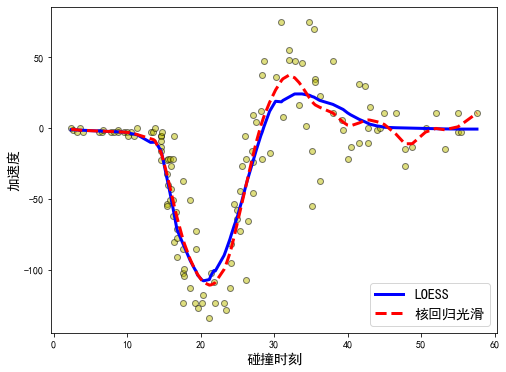

In [16]:
'''
摩托车碰撞例子的两种回归曲线。
'''
xout, yout, weigts = loess_1d(np.array(mc1),np.array(mc2), frac=0.3)
data3=pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.figure(figsize=(8,6))
plt.plot(data3[0], data3[1], 'b', linewidth=3, label='LOESS')
result = smn.KernelReg(mc2,mc1,var_type='c').fit()
data4  = pd.DataFrame(np.c_[mc1,result[0]]).sort_values(by=0)
plt.plot(data4[0],data4[1],'r--',label='核回归光滑',lw=3)

plt.xlabel('碰撞时刻',size=14)
plt.ylabel('加速度',size=14)
plt.scatter(mc1,mc2,c='y',edgecolor='k',alpha=0.5)
plt.legend(fontsize=14, loc='lower right')
plt.show()

### 8.8.3 LOWESS稳健回归
- #### 基本原理
先用局部线性估计进行拟合，然后定义稳健的权数并进行平滑，重复迭代若干次即可消除异常数据的影响。


- #### 例3：
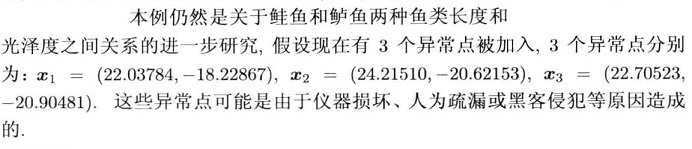

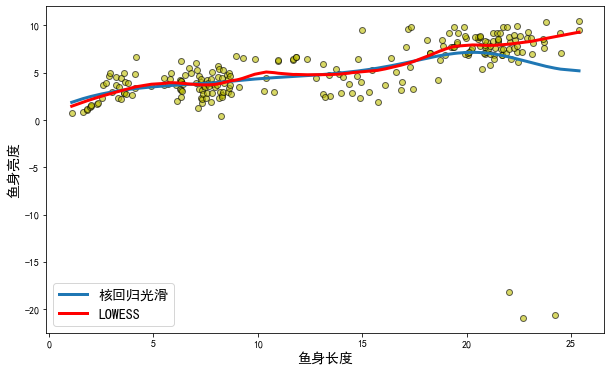

In [17]:
'''
本例在鱼类数据中增加了三个严重离群点数据。
'''
###加入离群点或异常数据
x1=np.concatenate([np.array(fish.length),np.array([22.03784,24.21510,22.70523])],axis=0)
y1=np.concatenate([np.array(fish.luminous),np.array([-18.22867,-20.62153,-20.90481])],axis=0)

###LOWESS稳健回归
lowess_fish=smn.lowess(y1,x1,frac=0.3)  
###核回归光滑模型
result = smn.KernelReg(y1,x1,bw=[2.55],var_type='c').fit()
data1  = pd.DataFrame(np.c_[x1,result[0]])
data1 = data1.sort_values(by=0)

###绘制两种回归模型的曲线
plt.figure(figsize=(10,6))
plt.scatter(x1,y1,facecolor='y',edgecolor='k',alpha=0.6)
plt.plot(data1[0],data1[1],label='核回归光滑',lw=3)
plt.plot(lowess_fish[:,0],lowess_fish[:,1],'r',lw=3,label='LOWESS')

plt.xlabel('鱼身长度',size=14)
plt.ylabel('鱼身亮度',size=14)

plt.legend(fontsize=14,loc='lower left')
plt.show()

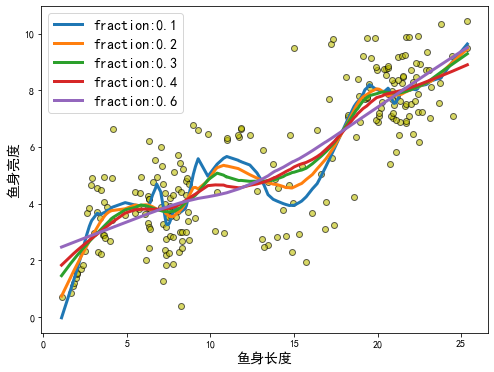

In [18]:
'''
使用不同frac参数进行LOWESS回归，该参数功能和LOESS一样。
'''
plt.figure(figsize=(8,6))
plt.scatter(m1,m2,facecolor='y',edgecolor='k',alpha=0.6)
plt.xlabel('鱼身长度',size=14)
plt.ylabel('鱼身亮度',size=14)
x = np.array(fish.length)
y = np.array(fish.luminous)
fracs = [0.1,0.2,0.3,0.4,0.6]
for f in fracs:
    lowess_fish=smn.lowess(y,x,frac=f)  
    plt.plot(lowess_fish[:,0],lowess_fish[:,1],label='fraction:'+str(f),lw=3)
plt.legend(fontsize=14)
plt.show()

### 8.8.4 k近邻回归


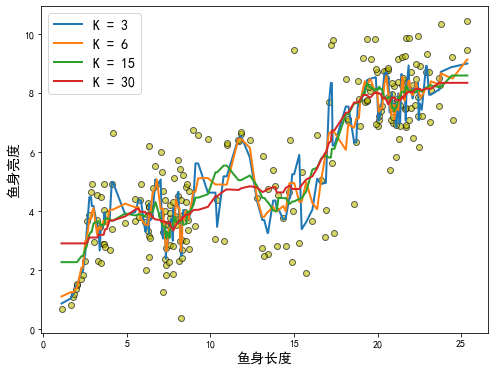

In [19]:
'''
使用sklean的KNeighborsRegressor对鱼类数据进行k近邻回归。
'''
from sklearn.neighbors import KNeighborsRegressor
###k值的设定，4个选项
neighbors=[3,6,15,30]
plt.figure(figsize=(8,6))
plt.scatter(m1,m2,facecolor='y',edgecolor='k',alpha=0.6)
###分别绘制4个k值的k近邻回归曲线。
for neighbor in neighbors:    
    dis_knr = KNeighborsRegressor(weights="uniform",n_neighbors=neighbor)
    result=dis_knr.fit(np.matrix(m1).T,m2)
    pre1=result.predict(np.matrix(m1).T)
    data5=pd.DataFrame(np.c_[m1,pre1]).sort_values(by=0)
    plt.plot(data5[0],data5[1],lw=2,label='K = '+str(neighbor))
plt.xlabel('鱼身长度',size=14)
plt.ylabel('鱼身亮度',size=14)
plt.legend(fontsize=14)
plt.show()

### 8.8.5 正交序列回归与样条回归


- #### (1) 正交序列回归

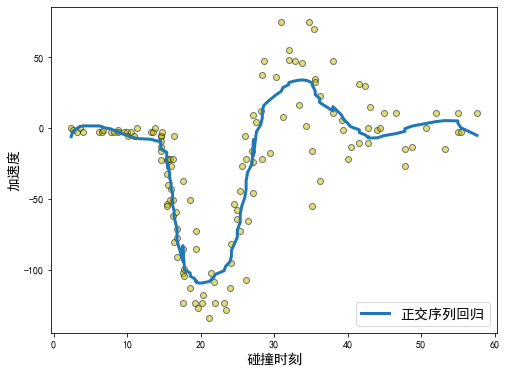

In [20]:
'''
使用《第4章 回归分析》一章介绍的正交多项式回归，原理此处不再赘述。
'''
from patsy import Poly
x=mc.times
y=mc.accel
data = {'x':x,'y':y}

#缺省情况下，该函数返回的阶数等于样本数据量
orthPoly  = lambda x,order:Poly().code_without_intercept(x).matrix[:,0:order]
formula = 'y~1+orthPoly(x,8)'
orthpoly_model = smf.ols(formula=formula,data=data)
result = orthpoly_model.fit()
result.summary()
y_hat=result.predict()
r_data=pd.DataFrame(np.c_[x,y_hat]).sort_values(by=0)
plt.figure(figsize=(8,6))
plt.scatter(x,y,facecolor='y',edgecolor='k',alpha=0.5)
plt.plot(r_data[0],r_data[1],lw=3,label='正交序列回归')
plt.xlabel('碰撞时刻',size=14)
plt.ylabel('加速度',size=14)
plt.legend(fontsize=14,loc='lower right')
plt.show()

- #### (2) B样条回归

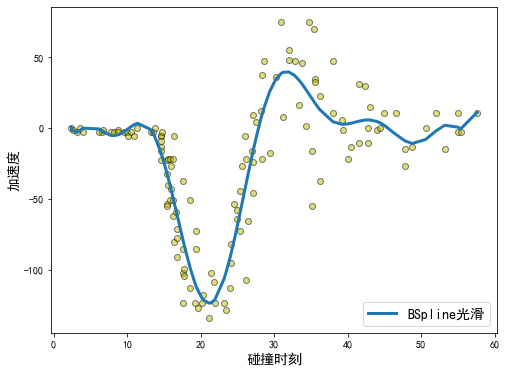

In [21]:
'''
B样条（B Spline）回归。要求样条基的阶较高。
'''
xspl = sm.gam.BSplines(mc1,df=15,degree=14)
formula = 'y~x'
#增加了离群点之后进行线性回归样条拟合
result = smf.ols(formula,{'y':mc2,'x':xspl.basis}).fit()
pred = result.get_prediction()
spres = pd.DataFrame(np.c_[mc1,pred.predicted_mean]).sort_values(by=0)
plt.figure(figsize=(8,6))

#使用回归样条绘制光滑曲线
plt.plot(spres[0],spres[1],label='BSpline光滑',lw=3)
plt.scatter(x,y,facecolor='y',edgecolor='k',alpha=0.5)
plt.xlabel('碰撞时刻',size=14)
plt.ylabel('加速度',size=14)
plt.legend(fontsize=14,loc='lower right')

plt.show()

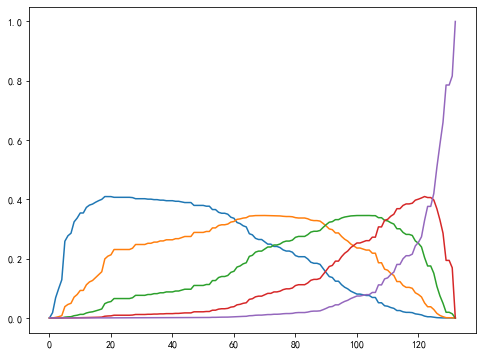

In [22]:
'''
摩托碰撞数据，碰撞时刻的B样条基函数。
'''
###通过广义可加模型的BSplines生成B样条基。
xspl = sm.gam.BSplines(mc1,df=6,degree=5)
plt.figure(figsize=(8,6))
for i in range(xspl.basis.shape[1]):
    plt.plot([i for i in range(xspl.basis.shape[0])],xspl.basis[:,i])
plt.show()

- #### (3) 三次样条回归

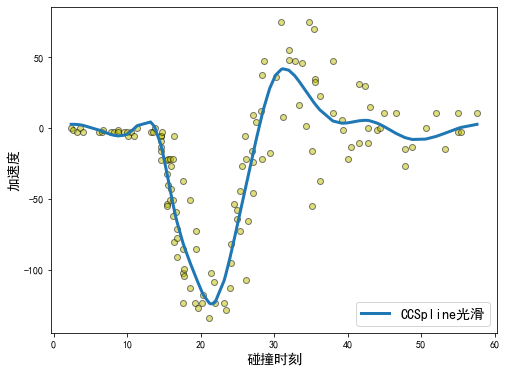

In [23]:
'''
三次样条，当样条基的阶数大14时，拟合效果不错。
'''
ccspl = sm.gam.CyclicCubicSplines(mc1,df=[14])
formula_ccspl = 'y~x'
res_ccspl = smf.ols(formula_ccspl,{'y':mc2,'x':ccspl.basis}).fit()

#获得回归模型的预测值，以原x变量作为参数
ccpres = res_ccspl.get_prediction()
ccsprest = pd.DataFrame(np.c_[x,ccpres.predicted_mean]).sort_values(by=0)
plt.figure(figsize=(8,6))

#使用回归样条进行绘制光滑曲线
plt.plot(ccsprest[0],ccsprest[1],label='CCSpline光滑',lw=3)
plt.scatter(mc1,mc2,facecolor='y',edgecolor='k',alpha=0.5)
plt.xlabel('碰撞时刻',size=14)
plt.ylabel('加速度',size=14)
plt.legend(fontsize=14,loc='lower right')
plt.show()

------------------------------

## <div align='center'>----------结束----------</div>